# Sparse Autoencoder based Feature Selection - Per Sequence

### 1. Reading and Processing the stable radiomic features

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import numpy as np

In [3]:
OUT_PATH=r"./results"
FEAT_PATH = r"./features_StudySettings3D.csv"
INT_ICC_PATH = r"./stability_study_results/INT_Clinical/inout_plane_systematic_features_StudySettings3D.csv"
EXT_ICC_PATH = r"./stability_study_results/QIN_NonClinical_Dependent/inout_plane_systematic_features_StudySettings3D.csv"

SEQUENCE_BESTFILTER_PREFIX = {
    
                "t2w":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"],
               
                "adc":["original_shape","log-sigma-5-0-mm-3D_firstorder","square_glcm","exponential_glszm","exponential_glrlm","exponential_gldm","exponential_ngtdm"],
                
                "dce_win":["original_shape","logarithm_firstorder","logarithm_glcm","wavelet-HLL_glszm","logarithm_glrlm","square_gldm","logarithm_ngtdm"],
                
                "dce_wout":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"]
                
               }

ICC_THRESHOLD = 0.90

In [4]:
feat_df = pd.read_csv(FEAT_PATH)
int_icc_df = pd.read_csv(INT_ICC_PATH, index_col=0)
ext_icc_df = pd.read_csv(EXT_ICC_PATH, index_col=0)

In [5]:
selected_feats = {}

for i, row_int  in int_icc_df.iterrows():
    
    feature, _, c_down_int, _, sequence = row_int
       
    row_ext = ext_icc_df[ext_icc_df.feature==feature][ext_icc_df.sequence==sequence.split("_")[0]]#this is because for internal set there is dce_win and dce_wout, but for external there is only dce
    
    _, _, c_down_ext, _, _ = row_ext.values[0].tolist()

    if c_down_int>=ICC_THRESHOLD and c_down_ext>=ICC_THRESHOLD:
    
        prefices = SEQUENCE_BESTFILTER_PREFIX[sequence]

        for prefix in prefices:

            if prefix in feature:
                selected_feats.setdefault(sequence,[]).append(feature)
                

c:\sithin\myenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


### 2. Sort Features In an Orderly Way (Pearson correlation is dependent on that, Simple to Complex features)

In [6]:
def sort_feats(features):

    sorted_features = []

    for feat_type in ["shape","firstorder","glcm","glszm","glrlm","gldm","ngtdm"]:

        feats = sorted([feat for feat in features if feat_type in feat and feat not in sorted_features])

        sorted_features += feats
            
    return sorted_features
        

#### Sorting Features Per Sequence 

In [7]:
for sequence in selected_feats.keys():
    
    selected_feats[sequence] = sort_feats(selected_feats[sequence])

### 3. Creating dataframe for each sequence with the selected features

In [8]:
dfs = {}

for sequence,feats in selected_feats.items():
    
    dfs[sequence] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])[feats]
    dfs[sequence]["label"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])['label']
    dfs[sequence]["id"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])['id']
    
                

#### Class Distribution

In [9]:
for sequence in selected_feats.keys():
    
    print(sequence,dfs[sequence]["label"].value_counts().to_dict())
    

t2w {0: 69, 1: 31}
adc {0: 69, 1: 31}
dce_win {0: 69, 1: 31}
dce_wout {0: 69, 1: 31}


### 4. Removing features with zero variance for each sequence

In [10]:
var_threshold = 0.0

In [11]:
for sequence,features in selected_feats.items():
    
    feats,var_tags = zip(*((dfs[sequence][features].var()<=var_threshold).to_dict()).items())
    low_variance_features = list(np.array(feats)[np.array(var_tags)])
    
    selected_feats[sequence] = sort_feats(list(set(features) - set(low_variance_features)))
    
    print(f"Removed {len(low_variance_features)}; {len(selected_feats[sequence])} remaining")

    

Removed 0; 54 remaining
Removed 0; 79 remaining
Removed 0; 91 remaining
Removed 0; 97 remaining


### 5. Shape and Volume Correlated Feature Filtering for each sequence

In [12]:
R_THRESHOLD = 0.85

In [13]:
#Removing Features Correlated with Shape

for sequence,feats in selected_feats.items():
    
    print(f"For {sequence}:")

    to_drop = []
    corr = dfs[sequence][feats].corr(method="pearson").abs()
    corr_dict = corr.to_dict()

    for feat in feats:

        if "original_shape" in feat: #original_shape_VoxelVolume will also be selected

            _to_drop = [key for key,val in corr_dict[feat].items() if val>=R_THRESHOLD and key not in to_drop]
            to_drop += _to_drop

    feats = list(set(feats)-set(to_drop))
    selected_feats[sequence] = sort_feats(feats)
    print(f"{len(to_drop)} highly shape correlated features deleted, {len(selected_feats[sequence])} features remaining")



For t2w:
16 highly shape correlated features deleted, 38 features remaining
For adc:
15 highly shape correlated features deleted, 64 features remaining
For dce_win:
14 highly shape correlated features deleted, 77 features remaining
For dce_wout:
13 highly shape correlated features deleted, 84 features remaining


### 6. Feautre filtering using pearson correlation coefficient for each sequence

Didn't do this because AE needs correlated features as input to effectively encode them

In [14]:
# R_THRESHOLD = 0.85

In [15]:
# for sequence,_df in dfs.items():
    
#     corr = _df[selected_feats[sequence]].corr(method='pearson').abs()
    
#     up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
    
#     to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
    
#     selected_feats[sequence] = sort_feats(list(set(selected_feats[sequence]) - set(to_drop)))

#     print(f"{len(to_drop)} highly correlated features deleted in sequence {sequence.upper()}, {len(selected_feats[sequence])} features remaining")
    

#### Visualizing clusters using PCA and t-SNE

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [17]:
SEED = 0

In [18]:
def visualize(features, labels, n_components, sequence):
 
    features = features.copy()
    
    scaler = StandardScaler()#it is necessary to ensure that the scale is similar
    features = scaler.fit_transform(features)

    embedding = {}
    
    embedding["pca"] = PCA(n_components = n_components, random_state=SEED).fit_transform(features)
    embedding["tsne"] = TSNE(n_components=n_components,random_state=SEED).fit_transform(features)
        
    
    # initialising the plot
    
    fig = plt.figure()
    
    for i,key in enumerate(embedding.keys()):
    
        ax = fig.add_subplot(1,2,i+1)

        # plotting data
        ax.scatter(*zip(*embedding[key][np.where(labels==1)]),marker='o',color='r',s=10,alpha=0.7,label='Class-1')
        ax.scatter(*zip(*embedding[key][np.where(labels==0)]),marker='o',color='g',s=10,alpha=0.3,label='Class-0')
        ax.set_title(f"{sequence}-{key}")
        ax.legend()

    

    plt.show
    

c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change

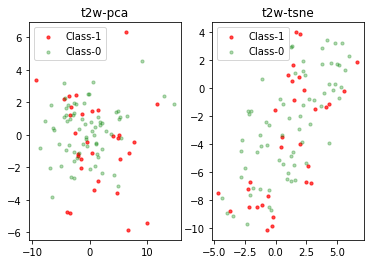

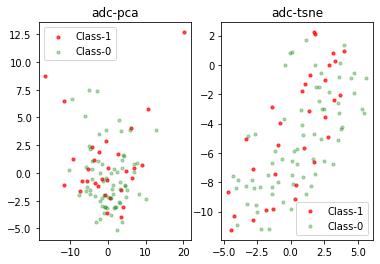

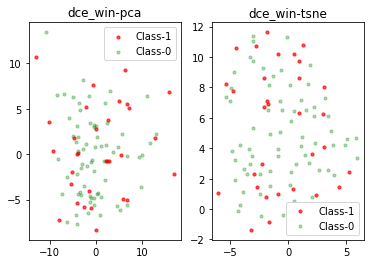

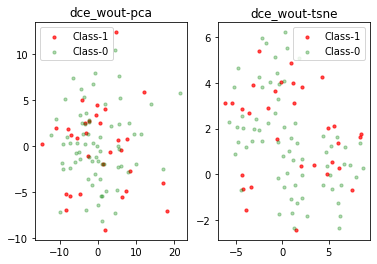

In [19]:
num_components = 2

for sequence in ["t2w","adc","dce_win","dce_wout"]:
    
    feats = dfs[sequence][selected_feats[sequence]].to_numpy()
    labels = dfs[sequence]["label"].to_numpy()
    
    visualize(feats, labels, num_components,sequence)

### 7. Defining AE Components

In [20]:
import time
import copy
import torch
import torch.nn as nn

#### Dataset

In [21]:
class TensorDataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        
        self.X = X
        
    def __len__(self):
        
        return len(self.X)
    
    def __getitem__(self, i):
        
        X = self.X[i]

        return X
            
                  

#### Module and Utils

In [22]:
class Module(nn.Module):
    
    def __init__(self, input_dim, latent_dim=8):
        
        super(Module, self).__init__()
        
        self.encoder = nn.Sequential(*[
            nn.Linear(input_dim,latent_dim * 2**3), nn.ReLU(), 
            nn.Linear(latent_dim * 2**3 , latent_dim * 2**2 ), nn.ReLU(),
            nn.Linear(latent_dim * 2**2 ,latent_dim * 2), nn.ReLU(),
            nn.Linear(latent_dim * 2,latent_dim), nn.Sigmoid()
        ])
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim, latent_dim * 2), nn.ReLU(),
            nn.Linear(latent_dim * 2 , latent_dim * 2**2), nn.ReLU(),
            nn.Linear(latent_dim * 2**2 ,latent_dim * 2**3), nn.ReLU(),
            nn.Linear(latent_dim * 2**3, input_dim)
            
        ])

        
    def forward(self, x):
        
        x = h = self.encoder(x)
        x = self.decoder(x)
        
        return h, x
        


In [23]:
class Model:
    
    def __init__(self,module):
        
        self.module = module
        
    def compile(self, lr, h_lambda, criterion, cuda_device_id=0):
        
        self.criterion = criterion
        self.h_lambda = h_lambda
        self.optimizer = torch.optim.AdamW(self.module.parameters(), lr)
        #self.device = torch.device(f'cuda:{cuda_device_id}' if torch.cuda.is_available() else "cpu")
        self.device = torch.device("cpu")
        self.module.to(self.device)
        
        return self.module
        
    def fit(self, dls, num_epochs,verbose=True):
        
        
        since = time.time()
        
        hist = {'train':{'loss':[]},'val':{'loss':[]}}
        
        best_model_wts = copy.deepcopy(self.module.state_dict())
        best_loss = np.inf
        
        for epoch in range(num_epochs):
            
            if verbose:
                
                print('Epoch {}/{}'.format(epoch,num_epochs-1))
                print('-'*10)
                
                
            for phase in ['train','val']:
  
                if phase=='train':
                    self.module.train()
                else:
                    self.module.eval()

                running_loss = 0.0
                
                for X in dls[phase]:
                    
                    X = X.to(self.device)
                    
                    self.optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase=='train'):
                
                        h, _X = self.module(X)
    
                        loss = self.criterion(_X,X) + self.h_lambda * h.flatten().abs().sum()
                        
                      
                        if phase=='train':
                            loss.backward()
                            self.optimizer.step()
                
                            running_loss += loss.item() 
                        
                if phase=="train":
                    epoch_loss = running_loss/len(dls[phase])
                else:
                    epoch_loss = loss

                if verbose:
                    print("{} Loss :{:.4f}".format(phase,epoch_loss))
                    
                if torch.isnan(loss):
                    return

                hist[phase]['loss'].append(epoch_loss)

                if phase == "val":

                    if epoch_loss<best_loss:
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(self.module.state_dict())
                            
            if verbose:
                print()
            
    
        time_elapsed = time.time() - since

        if verbose:
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('Best val Loss: {:4f}'.format(best_loss))

        self.module.load_state_dict(best_model_wts)

        return self.module.cpu(), best_loss
                    

In [24]:
def train_val_split(X,y):
    
    normal_indeces = np.argwhere(y==0).ravel()
    anomaly_indeces = np.argwhere(y==1).ravel()
    
    np.random.shuffle(normal_indeces)
    
    train_indeces = normal_indeces[:-len(anomaly_indeces)]
    val_indeces = normal_indeces[-len(anomaly_indeces):]
    test_indeces = np.concatenate([normal_indeces[-len(anomaly_indeces):],anomaly_indeces])

    
    X_train = X[train_indeces]
    y_train = y[train_indeces]
    
    
    X_val = X[val_indeces]
    y_val = y[val_indeces]
    
    
    X_test = X[test_indeces]
    y_test = y[test_indeces]
    
    
    return X_train,X_val,X_test, y_train,y_val, y_test
    

### 8. Feature Selection using AE

In [25]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [26]:
num_repeats = 100
batch_size = 32
criterion = nn.L1Loss()
latent_dim = 4
h_lambda = 1e-1
lr = 1e-2
num_epochs = 1000

In [27]:
out_path = os.path.join(OUT_PATH,"per_sequence")
if not os.path.exists(out_path):
    os.makedirs(out_path)

if os.path.exists(os.path.join(out_path,"exe_stat.npy")):
    exe_stat = np.load(os.path.join(out_path,"exe_stat.npy"),allow_pickle=True).item()
else:
    exe_stat = {}

In [28]:
if not os.path.exists(os.path.join(out_path,"recon_dfs.npy")):

    recon_dfs = {}
    exe_stat["autoencoder"]={}

    for sequence,features in selected_feats.items():
        
        print(f"Running experiments for {sequence}")
        
        start_time = time.time()
        
        columns = ["recon_err_"+feat_name for feat_name in features] + ["recon_err_mean", "label", "repeat_id"]
        recon_dfs[sequence] = {column:[] for column in columns}

        scaler = MinMaxScaler()

        X = dfs[sequence][features].to_numpy()
        y = dfs[sequence]["label"].to_numpy().ravel()
        

        for n in tqdm(range(num_repeats),desc="Repeat Progress"):
            
            X_train, X_val, X_test, y_train, y_val, y_test = train_val_split(X,y)

            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

            X_train = torch.from_numpy(X_train).float()
            X_val = torch.from_numpy(X_val).float()
            X_test = torch.from_numpy(X_test).float()

            y_test = torch.from_numpy(y_test).int()#storing labels

            train_ds = TensorDataset(X_train)
            train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

            dls = {"train":train_dl, "val":[X_val]}

            in_dim = X.shape[1]
            
            
            #print(f"Repeat:{i}/{num_repeats}\n")
            module = Module(in_dim, latent_dim)
            model = Model(module)

            model.compile(lr, h_lambda, criterion)
            best_module, loss = model.fit(dls,num_epochs,verbose=False)

            h, _X_test = best_module(X_test)

            recon_errs = torch.abs(X_test - _X_test)

            for i,feat in enumerate(features):
                recon_dfs[sequence]["recon_err_"+feat] += list(recon_errs[:,i].detach().numpy())
            recon_dfs[sequence]["recon_err_mean"] += list(recon_errs.mean(1).detach().numpy())
            recon_dfs[sequence]["label"] += list(y_test.detach().numpy())
            recon_dfs[sequence]["repeat_id"] += [n] * len(y_test)
            
        recon_dfs[sequence] = pd.DataFrame.from_dict(recon_dfs[sequence])
        exe_stat["autoencoder"][sequence] = time.time() - start_time
        
    np.save(os.path.join(out_path,"exe_stat.npy"),exe_stat)
    np.save(os.path.join(out_path,"recon_dfs.npy"),recon_dfs)

else:
    recon_dfs = np.load(os.path.join(out_path,"recon_dfs.npy"),allow_pickle=True).item()
    exe_stat = np.load(os.path.join(out_path,"exe_stat.npy"),allow_pickle=True).item()
    

exe_time = exe_stat["autoencoder"]
    
print(f"Autoencoder => Execution Time:{exe_time}")

Autoencoder => Execution Time:{'t2w': 625.2040584087372, 'adc': 639.7319610118866, 'dce_win': 647.8577082157135, 'dce_wout': 652.7266817092896}


In [29]:
exe_stat

{'LogisticRegression': {'t2w': 203.43559980392456,
  'adc': 530.0274002552032,
  'dce_win': 476.9047999382019,
  'dce_wout': 524.3803999423981},
 'SVC': {'t2w': 67.16739988327026,
  'adc': 128.03200006484985,
  'dce_win': 130.78460001945496,
  'dce_wout': 114.55279994010925},
 'RandomForestClassifier': {'t2w': 3675.824202299118,
  'adc': 6980.980010271072,
  'dce_win': 7073.5441999435425,
  'dce_wout': 6278.246799707413},
 'autoencoder': {'t2w': 625.2040584087372,
  'adc': 639.7319610118866,
  'dce_win': 647.8577082157135,
  'dce_wout': 652.7266817092896}}

#### Mean reconstruction error boxplot

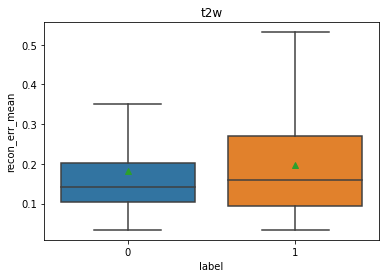

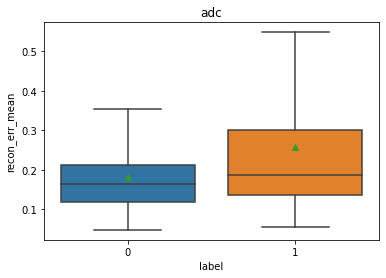

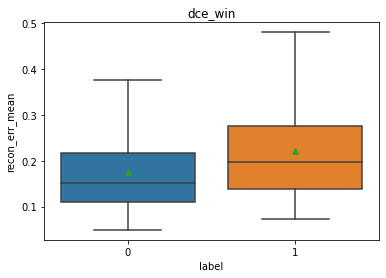

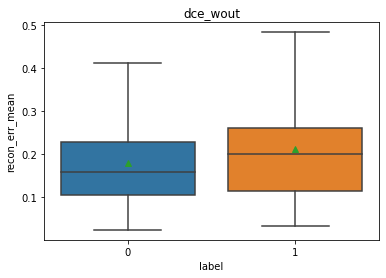

In [30]:
for sequence,recon_df in recon_dfs.items():

    sns.boxplot(x='label',y="recon_err_mean",data=recon_df, showfliers=False,showmeans=True).set_title(sequence)
    plt.show()

t2w


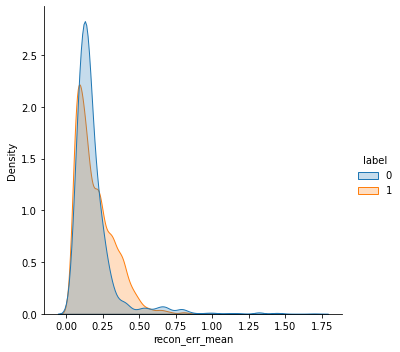

adc


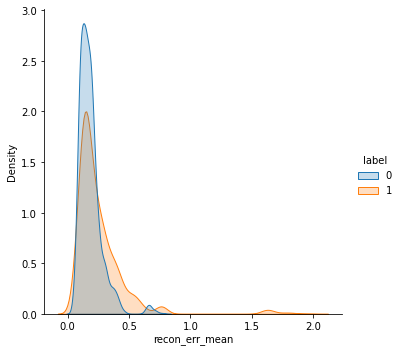

dce_win


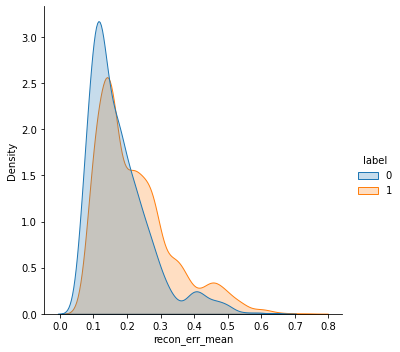

dce_wout


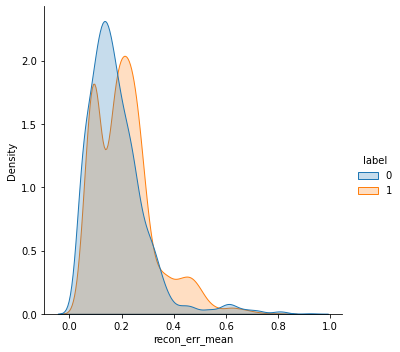

In [31]:
for sequence,recon_df in recon_dfs.items():
    print(sequence)
    sns.displot(data=recon_df,x="recon_err_mean", hue="label", kind="kde", fill=True)
    plt.show()

t2w


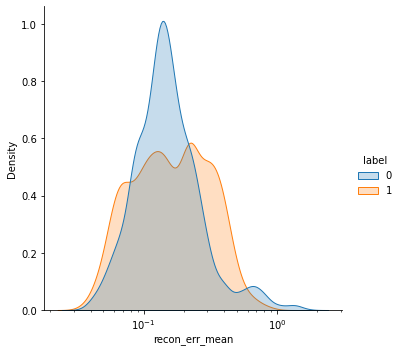

adc


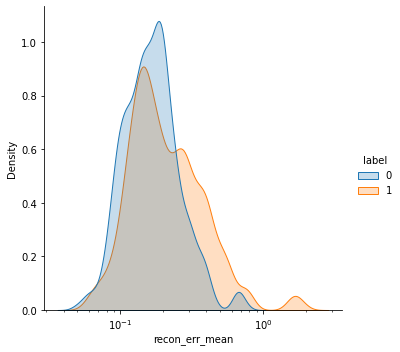

dce_win


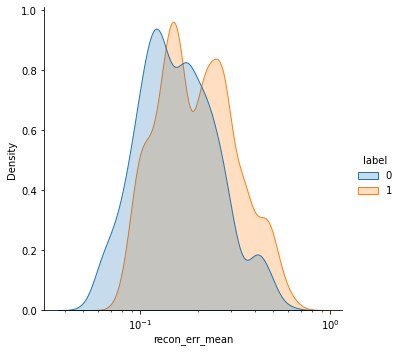

dce_wout


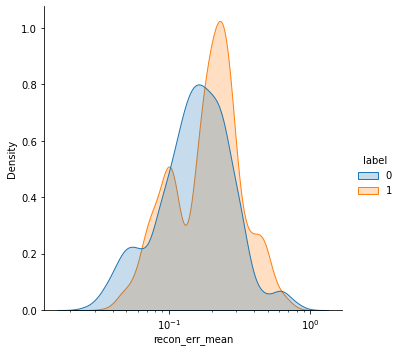

In [32]:
for sequence,recon_df in recon_dfs.items():
    print(sequence)
    sns.displot(data=recon_df,x="recon_err_mean", hue="label", kind="kde", fill=True, log_scale=True)
    plt.show()

### 9. Compute Delta based on the difference of mean reconstruction error grouped by label for each sequence

In [33]:
deltas = {}

In [34]:
for sequence,recon_df in recon_dfs.items():

    temp_df = recon_df.copy()
    temp_df = temp_df.groupby(by="label").mean()

    print(temp_df["recon_err_mean"].to_dict())

    temp_df.pop("recon_err_mean")
    temp_df.pop("repeat_id")

    delta = temp_df.loc[1]-temp_df.loc[0]
    deltas[sequence] = dict(sorted(delta.items(), key=lambda item: item[1],reverse=True))#sort in descending order of delta

{0: 0.1828991174697876, 1: 0.19659017026424408}
{0: 0.18241314589977264, 1: 0.25687897205352783}
{0: 0.17553773522377014, 1: 0.22178208827972412}
{0: 0.17950358986854553, 1: 0.21181873977184296}


### 10. Removing Correlated Features in Delta for each Sequence

In [35]:
filtered_features = {}

In [36]:
for sequence,delta in deltas.items():

    R_THRESHOLD = 0.85

    features,_ = zip(*delta.items())#essentially getting the ordered features based on the delta value
    features = [feat.replace("recon_err_","") for feat in list(features)]

    corr = dfs[sequence][features].corr(method="pearson").abs()#order matters actually here
    up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
    to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
    _filtered_features = list(set(features)-set(to_drop))


    print(f"{len(to_drop)} highly correlated features deleted, {len(_filtered_features)} features remaining")
    
    filtered_features[sequence] = _filtered_features


27 highly correlated features deleted, 11 features remaining
48 highly correlated features deleted, 16 features remaining
60 highly correlated features deleted, 17 features remaining
69 highly correlated features deleted, 15 features remaining


#### Delta after removing correlated features

In [37]:
deltas_filtered = {}

In [38]:
for sequence,_filtered_features in filtered_features.items():

    delta_filtered = {}
    for feat in _filtered_features:
        delta_filtered[feat] = deltas[sequence]["recon_err_"+feat]

    deltas_filtered[sequence] = dict(sorted(delta_filtered.items(), key=lambda item: item[1],reverse=True))

#### Visualizing the top 10 features for each sequence

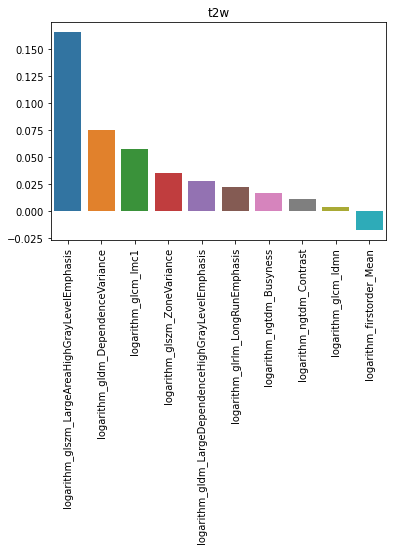

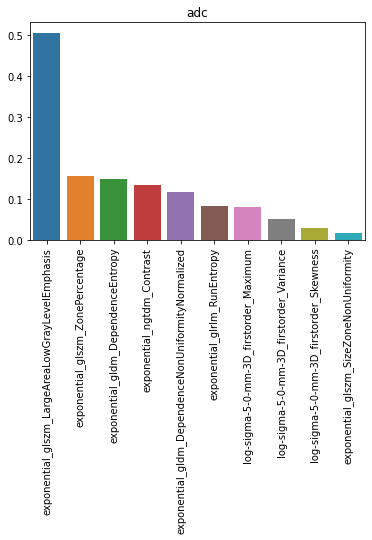

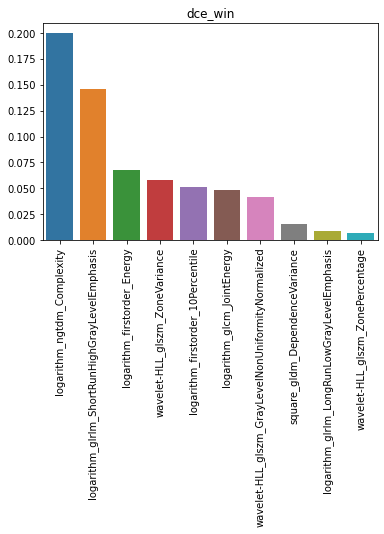

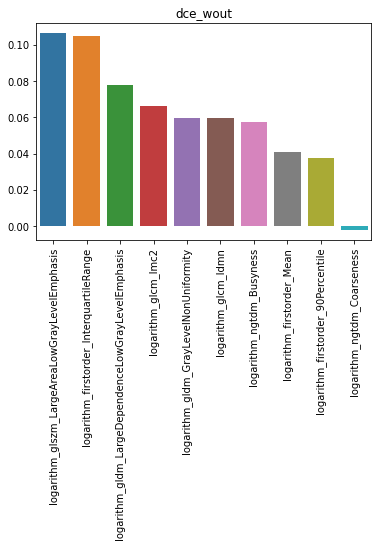

In [39]:
for sequence,delta_filtered in deltas_filtered.items():

    %matplotlib inline
    x,y = zip(*delta_filtered.items())

    sns.barplot(x=list(x)[:10],y=list(y)[:10]).set_title(sequence)
    plt.xticks(rotation=90)
    plt.show()


### 11. Merge delta from each sequence to generate a single rank df and sort by rank ; also construct a merged df

(sorting for performing corr analysis)

In [40]:
rank_df = {}
merged_df = {}

rank_df["feature"] = []
rank_df["delta"] = []
rank_df["rank"] = []
rank_df["sequence"] = []
rank_df["merged_feature"] = []

for sequence,delta_filtered in deltas_filtered.items():
    
    i = 1

    for feat,delta in delta_filtered.items():

        rank_df["feature"].append(feat)
        rank_df["delta"].append(delta)
        rank_df["rank"].append(i)
        rank_df["sequence"].append(sequence)
        rank_df["merged_feature"].append(sequence+"_"+feat)
        
        merged_df[sequence+"_"+feat] = dfs[sequence].sort_values(by=["id"])[feat].values

        i += 1
        
merged_df["id"] = dfs[sequence].sort_values(by=["id"])["id"].values
merged_df["label"] = dfs[sequence].sort_values(by=['id'])["label"].values

rank_df = pd.DataFrame.from_dict(rank_df).sort_values(by=['rank'])
merged_df = pd.DataFrame.from_dict(merged_df)

### 12. Removing Correlated Features in the rank df and exporting it

In [41]:
R_THRESHOLD = 0.85

In [42]:
merged_features = rank_df.merged_feature.to_list()

corr = merged_df[merged_features].corr(method="pearson").abs()#order matters actually here
up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
merged_features_filtered = list(set(merged_features)-set(to_drop))


print(f"{len(to_drop)} highly correlated features deleted, {len(merged_features_filtered)} features remaining")

rank_df = rank_df[rank_df.merged_feature.isin(merged_features_filtered)].sort_values(by=["rank"])

rank_df.to_csv(os.path.join(out_path,"autoencoder.csv"),index=False)


0 highly correlated features deleted, 59 features remaining


#### Visualizing the top 10 radiomic features

In [43]:
rank_df.head(10)

,feature,delta,rank,sequence,merged_feature
0,logarithm_glszm_LargeAreaHighGrayLevelEmphasis,0.165690,1,t2w,t2w_logarithm_glszm_LargeAreaHighGrayLevelEmph...
44,logarithm_glszm_LargeAreaLowGrayLevelEmphasis,0.106679,1,dce_wout,dce_wout_logarithm_glszm_LargeAreaLowGrayLevel...
27,logarithm_ngtdm_Complexity,0.200003,1,dce_win,dce_win_logarithm_ngtdm_Complexity
11,exponential_glszm_LargeAreaLowGrayLevelEmphasis,0.505272,1,adc,adc_exponential_glszm_LargeAreaLowGrayLevelEmp...
1,logarithm_gldm_DependenceVariance,0.074928,2,t2w,t2w_logarithm_gldm_DependenceVariance
45,logarithm_firstorder_InterquartileRange,0.105066,2,dce_wout,dce_wout_logarithm_firstorder_InterquartileRange
28,logarithm_glrlm_ShortRunHighGrayLevelEmphasis,0.146073,2,dce_win,dce_win_logarithm_glrlm_ShortRunHighGrayLevelE...
12,exponential_glszm_ZonePercentage,0.156108,2,adc,adc_exponential_glszm_ZonePercentage
46,logarithm_gldm_LargeDependenceLowGrayLevelEmph...,0.077969,3,dce_wout,dce_wout_logarithm_gldm_LargeDependenceLowGray...
13,exponential_gldm_DependenceEntropy,0.147867,3,adc,adc_exponential_gldm_DependenceEntropy


#### Radiomics signature

In [44]:
NUM_FEATS = 4
radiomics_signature = rank_df.merged_feature.to_list()[:NUM_FEATS]

radiomics_signature 

['t2w_logarithm_glszm_LargeAreaHighGrayLevelEmphasis',
 'dce_wout_logarithm_glszm_LargeAreaLowGrayLevelEmphasis',
 'dce_win_logarithm_ngtdm_Complexity',
 'adc_exponential_glszm_LargeAreaLowGrayLevelEmphasis']

In [45]:
if os.path.exists(os.path.join(OUT_PATH,"signatures_sequence.csv")):
    signatures = pd.read_csv(os.path.join(OUT_PATH,"signatures_sequence.csv"))
else:
    signatures = pd.DataFrame.from_dict({})
    
signatures["AE_LogisticRegression"] = radiomics_signature
signatures["AE_SVC"]=radiomics_signature
signatures["AE_RandomForestClassifier"]=radiomics_signature

signatures.to_csv(os.path.join(OUT_PATH,"signatures_sequence.csv"),index=False)

### 13. ML pipeline for Signature Validation

Linear Model: LogisticRegression

Non Linear Model: SVM, RandomForestClassifier

In [46]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)#because of xgboost warnings

In [47]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#import xgboost as xgb

In [48]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=100,random_state=0)
estimators = [
    LogisticRegression(penalty='none'),
    SVC(),
    RandomForestClassifier()
]

#xgb.XGBClassifier(use_label_encoder=False,objective='binary:logistic',eval_metric="logloss")

In [50]:
for estimator in estimators:

    X = merged_df[radiomics_signature].to_numpy()
    y = merged_df["label"].to_numpy().ravel()
    
    estimator_pipeline = make_pipeline(StandardScaler(),estimator)
    results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc"],verbose=1,cv=rskf)
    
    roc_auc = results["test_roc_auc"]
    
    print(f"Estimator:{estimator.__class__.__name__}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")
   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:LogisticRegression, roc_auc:0.72+-0.087


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:SVC, roc_auc:0.71+-0.087
Estimator:RandomForestClassifier, roc_auc:0.73+-0.08


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   50.1s finished


# Permutation Test

In [51]:
from sklearn.model_selection import permutation_test_score

In [72]:
export_path = r"C:\Sithin\autoencoder\permutation_results\per-sequence"
if not os.path.exists(export_path):
    os.makedirs(export_path)

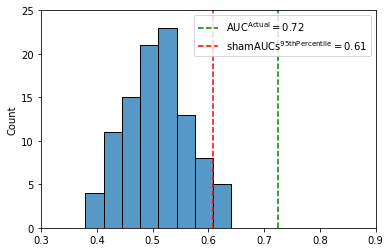

Estimator:LogisticRegression, Actual roc-auc: 0.7243768115942029, Range of sham roc-aucs:((0.3797140974967062, 0.6410619235836627)), p-value:0.009900990099009901, Distance:0.11609466403162061


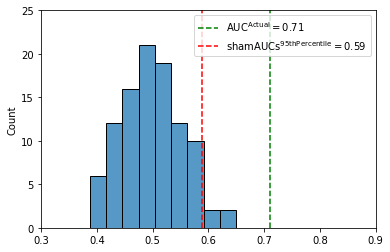

Estimator:SVC, Actual roc-auc: 0.7111159420289855, Range of sham roc-aucs:((0.38789459815546773, 0.6496205533596838)), p-value:0.009900990099009901, Distance:0.12268366271409759


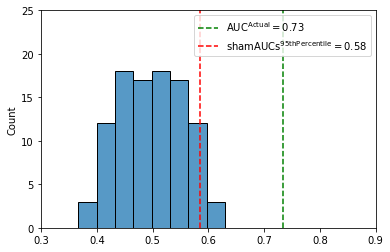

Estimator:RandomForestClassifier, Actual roc-auc: 0.7333563899868247, Range of sham roc-aucs:((0.36667654808959155, 0.6297470355731226)), p-value:0.009900990099009901, Distance:0.14861725955204208


In [73]:
if not os.path.exists(os.path.join(out_path,"ae_permutation_test.npy")):
    results = {}
    for estimator in estimators:
    
        radiomics_signature = signatures["AE_"+estimator.__class__.__name__].to_list()

        X = merged_df[radiomics_signature]
        y = merged_df["label"].to_numpy().ravel()

        estimator_pipeline = make_pipeline(StandardScaler(), estimator)
        mean_rocauc, permuted_rocaucs, p_value = permutation_test_score(estimator_pipeline, X, y, scoring="roc_auc",verbose=1,cv=rskf)

        results[estimator.__class__.__name__] = {"p_value":p_value,"mean_auc":mean_rocauc,"permuted_aucs":permuted_rocaucs}
        
    np.save(os.path.join(out_path,"ae_permutation_test.npy"),results)
    
else:
    results = np.load(os.path.join(out_path,"ae_permutation_test.npy"),allow_pickle=True).item()
    

# for estimator in results:
    
#     p_value = results[estimator]["p_value"]
#     mean_rocauc = results[estimator]["mean_auc"]
#     permuted_rocaucs = results[estimator]["permuted_aucs"]
    
#     sns.histplot(permuted_rocaucs)
#     plt.axvline(mean_rocauc)
#     plt.show()

#     distance = mean_rocauc - np.percentile(permuted_rocaucs, 95)

#     print(f"Estimator:{estimator.__class__.__name__}, Actual roc-auc: {mean_rocauc}, Range of sham roc-aucs:({min(permuted_rocaucs),max(permuted_rocaucs)}), p-value:{p_value}, Distance:{distance}")


for estimator in results:
    
    p_value = results[estimator]["p_value"]
    mean_rocauc = results[estimator]["mean_auc"]
    permuted_rocaucs = results[estimator]["permuted_aucs"]
    
    params = {'mathtext.default':'regular'}
    plt.rcParams.update(params)
    
    fig = plt.figure()
    ax = fig.gca()
    
    sns.histplot(permuted_rocaucs, ax=ax)
    ax.set_xlim(0.3,0.9)
    ax.set_ylim(0,25)
    plt.axvline(mean_rocauc, label="$AUC^{Actual}$"+f"$={mean_rocauc:0.2f}$", color='g', ls='--')
    
    percentile95 = np.percentile(permuted_rocaucs, 95)
    
    plt.axvline(percentile95, label="$shamAUCs^{95th Percentile}$"+f"$={percentile95:0.2f}$", color='r', ls='--')
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(export_path,f"main-{estimator}.png"),dpi=300)
    plt.show()

    distance = mean_rocauc - percentile95#np.percentile(permuted_rocaucs, 95)
    
    

    print(f"Estimator:{estimator}, Actual roc-auc: {mean_rocauc}, Range of sham roc-aucs:({min(permuted_rocaucs),max(permuted_rocaucs)}), p-value:{p_value}, Distance:{distance}")
    




# Fun Experiments

### 1. Majority Voting

In [ ]:
vote_dfs = {}

for sequence,recon_df in recon_dfs.items():

    temp_df = recon_df.groupby(by=["repeat_id","label"]).mean()

    vote_df = {}

    for i in recon_df.repeat_id.unique():


        vote_df.setdefault("repeat_id",[]).append(i)

        _delta = temp_df.loc[i,1] - temp_df.loc[i,0]
        _delta = dict(sorted(delta.items(), key=lambda item: item[1],reverse=True)) # soring the delta value

        feats,_ = zip(*_delta.items())

        for i,feat in enumerate(feats):
            vote_df.setdefault(feat,[]).append(i+1)




    vote_df = pd.DataFrame.from_dict(vote_df)
    vote_df.pop("repeat_id")
    vote_df.pop("recon_err_mean")
    
    vote_dfs[sequence] = vote_df

In [ ]:
majority_votes = {}

for sequence,vote_df in vote_dfs.items():
    
    majority_votes[sequence] = {}

    for column in vote_df.columns:

        if len(vote_df[column].unique())<len(vote_df[column]):

            majority_votes[sequence][column.replace("recon_err_","")] = (max(vote_df[column].mode()),deltas[sequence][column])
            
    majority_votes[sequence] = dict(sorted(majority_votes[sequence].items(), key=lambda item: item[1][0]))
    

In [ ]:
R_THRESHOLD = 0.85

majority_votes_filtered = {}

for sequence,majority_vote in majority_votes.items():
    
    majority_votes_filtered[sequence] = {}

    features,_ = zip(*majority_vote.items())#essentially getting the ordered features based on the delta value

    corr = dfs[sequence][list(features)].corr(method="pearson").abs()#order matters actually here
    up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
    to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
    filtered_features = list(set(features)-set(to_drop))

    print(f"{len(to_drop)} highly correlated features deleted, {len(filtered_features)} features remaining")
    
    for feat in filtered_features:
        majority_votes_filtered[sequence][feat] = majority_vote[feat]
    
    majority_votes_filtered[sequence] = dict(sorted(majority_votes_filtered[sequence].items(), key=lambda item: item[1]))


In [ ]:
rank_df = {}
merged_df = {}

rank_df["feature"] = []
rank_df["rank"] = []
rank_df["sequence"] = []
rank_df["merged_feature"] = []

for sequence,majority_vote_filtered in majority_votes_filtered.items():
    

    for feat,rank in majority_vote_filtered.items():

        rank_df["feature"].append(feat)
        rank_df["rank"].append(rank)
        rank_df["sequence"].append(sequence)
        rank_df["merged_feature"].append(sequence+"_"+feat)
        
        merged_df[sequence+"_"+feat] = dfs[sequence].sort_values(by=["id"])[feat].values

        
merged_df["id"] = dfs[sequence].sort_values(by=["id"])["id"].values
merged_df["label"] = dfs[sequence].sort_values(by=['id'])["label"].values

rank_df = pd.DataFrame.from_dict(rank_df).sort_values(by=['rank'])
merged_df = pd.DataFrame.from_dict(merged_df)

In [ ]:
merged_features = rank_df.merged_feature.to_list()

corr = merged_df[merged_features].corr(method="pearson").abs()#order matters actually here
up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
merged_features_filtered = list(set(merged_features)-set(to_drop))


print(f"{len(to_drop)} highly correlated features deleted, {len(merged_features_filtered)} features remaining")

rank_df = rank_df[rank_df.merged_feature.isin(merged_features_filtered)].sort_values(by=["rank"])


In [ ]:
rank_df

In [ ]:
#possible that multiple features were ranked 1; in such cases select the least correlated feature
candidate_feats = rank_df[rank_df["rank"]==1].merged_feature.to_list()
candidate_corr = merged_df[candidate_feats].corr(method="pearson").abs()

radiomics_signature = []

for sequence in ["t2w","adc","dce_win","dce_wout"]:
    
    feats = rank_df[rank_df.sequence==sequence][rank_df["rank"]==1].merged_feature.to_list()
    feat_corrs = {}
    
    for feat in feats:
        feat_corrs[feat] = (candidate_corr[feat][set(candidate_feats)-{feat}]).values.mean()

    
    radiomics_signature += [next(iter(dict(sorted(feat_corrs.items(),key=lambda item:item[1]))))]

In [ ]:
radiomics_signature

In [ ]:
# radiomics_signature = rank_df[rank_df["rank"]==1].merged_feature.to_list()[:NUM_FEATS]

# radiomics_signature 

In [ ]:
import itertools

In [ ]:

for estimator in estimators:

    X = merged_df[radiomics_signature].to_numpy()
    y = merged_df["label"].to_numpy().ravel()

    estimator_pipeline = make_pipeline(StandardScaler(),estimator)
    results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc"],verbose=1,cv=rskf)

    roc_auc = results["test_roc_auc"]

    print(f"Estimator:{estimator.__class__.__name__}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")


### 1. Using wasserstein distance instead of delta

In [ ]:
from scipy.stats import wasserstein_distance

In [ ]:
distances = {}

In [ ]:
for sequence,features in selected_feats.items():
    
    distance = {}

    for feat in features:

        U = recon_dfs[sequence]["recon_err_"+feat][recon_df.label==0].values
        V = recon_dfs[sequence]["recon_err_"+feat][recon_df.label==1].values

        distance[feat] = wasserstein_distance(U,V)
        
    distances[sequence] = dict(sorted(distance.items(), key=lambda item: item[1],reverse=True))


In [ ]:
R_THRESHOLD = 0.85

distances_filtered = {}

for sequence,distance in distances.items():
    
    distances_filtered[sequence] = {}

    features,_ = zip(*distance.items())#essentially getting the ordered features based on the delta value

    corr = dfs[sequence][list(features)].corr(method="pearson").abs()#order matters actually here
    up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
    to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
    filtered_features = list(set(features)-set(to_drop))

    print(f"{len(to_drop)} highly correlated features deleted, {len(filtered_features)} features remaining")
    
    for feat in filtered_features:
        distances_filtered[sequence][feat] = distance[feat]
    
    distances_filtered[sequence] = dict(sorted(distances_filtered[sequence].items(), key=lambda item: item[1],reverse=True))


In [ ]:
rank_df = {}
merged_df = {}

rank_df["feature"] = []
rank_df["distance"] = []
rank_df["rank"] = []
rank_df["sequence"] = []
rank_df["merged_feature"] = []

for sequence,distance_filtered in distances_filtered.items():
    
    i = 1

    for feat,distance in distance_filtered.items():

        rank_df["feature"].append(feat)
        rank_df["distance"].append(distance)
        rank_df["rank"].append(i)
        rank_df["sequence"].append(sequence)
        rank_df["merged_feature"].append(sequence+"_"+feat)
        
        merged_df[sequence+"_"+feat] = dfs[sequence].sort_values(by=["id"])[feat].values

        i += 1
        
merged_df["id"] = dfs[sequence].sort_values(by=["id"])["id"].values
merged_df["label"] = dfs[sequence].sort_values(by=['id'])["label"].values

rank_df = pd.DataFrame.from_dict(rank_df).sort_values(by=['rank'])
merged_df = pd.DataFrame.from_dict(merged_df)

In [ ]:
merged_features = rank_df.merged_feature.to_list()

corr = merged_df[merged_features].corr(method="pearson").abs()#order matters actually here
up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
merged_features_filtered = list(set(merged_features)-set(to_drop))


print(f"{len(to_drop)} highly correlated features deleted, {len(merged_features_filtered)} features remaining")

rank_df = rank_df[rank_df.merged_feature.isin(merged_features_filtered)].sort_values(by=["rank"])


In [ ]:
NUM_FEATS = 4
radiomics_signature = rank_df.merged_feature.to_list()[:NUM_FEATS]

radiomics_signature 

In [ ]:
for estimator in estimators:

    X = merged_df[radiomics_signature].to_numpy()
    y = merged_df["label"].to_numpy().ravel()

    estimator_pipeline = make_pipeline(StandardScaler(),estimator)
    results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc"],verbose=1,cv=rskf)

    roc_auc = results["test_roc_auc"]

    print(f"Estimator:{estimator.__class__.__name__}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")
